In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gabor_kernel
from tqdm import tqdm

import scipy.io
import imageio
from PIL import Image
from scipy import signal


# Task 3

A data matrix $Y$ is made up of two submatrices, $Y_1$ and $Y_2$ of size $I × J_n$. The task is to solve a distributed low-rank approximation by two agents, such that each agent has only one part of the data $Y$, and does not have access to the other parts of the data.

Derive the algorithms to update $\{U_n , V_n\}$ by the $n$-th agent for the following problem

\begin{align}
\min \quad & \frac{1}{2} || Y_1- U_1 V_1^T||^2_F + \frac{1}{2} ||Y_2 - U_2 V_2^T ||^2_F \\
\text{subject to } \quad & U_1 = U_2
\end{align}

Give an example of two agents fitting an image $Y$.

Report the approximation error
$$err_1 = ||Y_1 - U_1 V_1^T||^2_F + ||Y_2 - U_2 V_2^T ||^2_F$$
and the difference $||U_1 - U_2||^2_F$ between $U_1$ and $U_2$.

Check the approximation error after exchanging $U_1$ and $U_2$ in the two agents, i.e.,
$$err_2 = ||Y_1 - U_2 V_1^T||^2_F + ||Y_2 - U_1 V_2^T ||^2_F$$

Are the two approximation errors are significantly different?
If so, explain why the algorithm fails and reformulate the problem if possible.

The augmentage Lagrangian for the above optimization problem

$$L(U_1, U_2, V_1, V_2, T) = \frac{1}{2} || Y_1 - U_1 V_1^T||^2_F + \frac{1}{2} || Y_2 - U_2 V_2^T||^2_F + \frac{\lambda}{2}||U_1 - U_2 - T||^2_F$$
where $T$ is the dual variable associated to the equality constraint $U_1 = U_2$

The ADMM algorithm updates the variables in the following cycle:

•  Update $U_1$ and $V_1$ by solving the subproblem

$$\min_{U_1, V_1} { \frac{1}{2} \| Y_1 - U_1 V_1^T\|_F^2 + \frac{\lambda}{2} \| U_1 - U_2 - T_1 |_F^2 }.$$

•  Update $U_2$ and $V_2$ by solving the subproblem

$$\min_{U_2, V_2} { \frac{1}{2} \| Y_2 - U_2 V_2^T \|_F^2 + \frac{\lambda}{2} \| U_2 - U_1 + T \|_F^2 }.$$

•  Update $T$ by
$$T = T+ U_2 - U_1$$


We can derive the closed-form solutions for each subproblem as follows.

The subproblem for $U_1$ and $V_1$ can be written as:

$$\min_{U_1, V_1} \; \frac{1}{2} ||Y_1 - U_1 V_1^T ||^2_F + \frac{\lambda}{2} ||U_1-D||$$
where $D = U_2 + T$

The solution for $V_1$ is given by a least squares problem which has closed-form expression as
$$V_1^* = ((U_1^TU_1)^{-1}U_1^TY)^T$$

Substituting this into the objective function, we get

$$U_1 = \arg\min \frac{1}{2} ||Y_1 - U_1(U_1^TU_1)^{-1}U_1^T Y ||^2_g + \frac{\lambda}{2} ||U_1-D||^2_F$$

Let SVD of $U_1 = A \Sigma B^T$, we can simplify the optimization problem for $U_1$ as

$$\min_{U_1} \quad \frac{1}{2} ||Y - A \Sigma B^T (B\Sigma A^T A \Sigma B)^{-1} B \Sigma A^T Y||^2_F + \frac{\lambda}{2} || A \Sigma B^T - D||^2_F$$
where the first term is written as
\begin{align}
||Y_1 - A A^T Y_1 ||^2_F &= ||Y_1||^2_F + ||A A^T Y_1||^2_F - 2 tr(Y_1^TA A^T Y_1) \\
 &= ||Y_1||^2_F - ||A^T Y_1||^2_F
\end{align}

The problem is rewritten as
\begin{align}
\min \frac{1}{2} ||Y_1|^2_F - \frac{1}{2} ||A^T Y_1||^2_F + \frac{\lambda}{2} ||A \Sigma B^T - D||^2_F
\end{align}
which leads to the optimal $$\Sigma^{*} B^{*T}  = A^TD$$
and
$$||A\Sigma B^T - D||^2_F = ||D||^2_F - ||A^TD||^2_F$$

and the orthogonal matrix $A$ is solution to the following minization problem

\begin{align}
A &= \arg\min \quad \frac{1}{2} ||Y_1||^2_F - \frac{1}{2} ||A^T Y_1||^2_F + \frac{\lambda}{2}||D||^2_F - \frac{\lambda}{2} ||A^T D||^2_F\\
&= \arg\min - \frac{1}{2} ||A^T Y_1||^2_F - \frac{\lambda}{2} ||A^TD||^2_F \\
&= \arg\max \quad tr(A^T(Y_1 Y_1^T + \lambda D D^T) A)
\end{align}
or $A^*$ consists of the $R$ leading eigenvectors of the matrix $Y_1 Y_1^T + \lambda D D^T$

\begin{align}
U_1^* &= A A^T D\\
V_1^* &= (Y_1^T A)(D^T A)^{-1}
\end{align}

Similarly, we can derive the optimal solution $\{U_2^{*}, V_2^{*}\}$
as
\begin{align}
U_2^* &= A A^T D\\
V_2^* &= (Y_2^T A)(D^T A)^{-1}
\end{align}
where $A^*$ comprises $R$ principal components of the matrix $(Y_2Y_2^T + \lambda DD^T)$ with $D = U_1 - T$


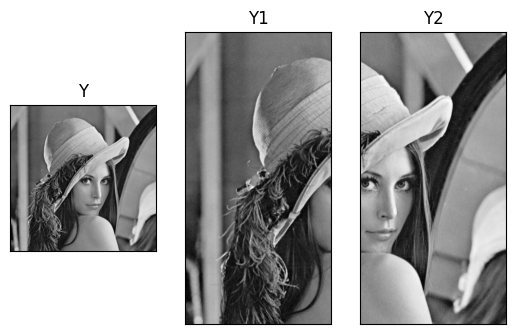

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = imageio.v3.imread("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")
img = Image.fromarray(img).resize((512,512))
img = img.convert("L")
img = np.array(img)

Y = np.asarray(img, dtype=np.float64)
Y = Y / 255

n, m = Y.shape
k = m // 2

Y1 = Y[:, :k]
Y2 = Y[:, k:]
Yc = [Y1, Y2]

plt.subplot(1,3,1)
plt.imshow(Y, cmap='gray')
plt.title('Y')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(Y1, cmap='gray')
plt.title('Y1')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(Y2, cmap='gray')
plt.title('Y2')
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
# define the function as a Python function
def mtx_distributed(Yk, D, R, lambda_):
  # f(U,V) = 1/2*norm(Y-U*V','fro')^2 + lambda/2 * norm(U-D,'fro')^2
  # convert the matrices Y and D to arrays
  Yk = np.array(Yk)
  D = np.array(D)
  # get the shape of Y
  sz = np.shape(Yk)

  Uu, eu, Vu = np.linalg.svd(np.concatenate((Yk, np.multiply(np.sqrt(lambda_), D)), axis=1)) # = U E V

  # extract the first R columns of the left singular matrix
  Uu = Uu[:, :R]
  # calculate the matrix Q
  Q = Uu.T @ D
  # calculate the factor U
  U = Uu @ Q

  # calculate the factor V
  V = np.linalg.solve(Q, Uu.T @ Yk)

  # return the factors U and V as the outputs of the function
  return U, V


def admm_lr_distributed(Yc, R, lambda_, Ux, Vx,verbose,maxiters = 100):
  # convert the cell array of matrices to a list of arrays
  Yc = list(map(np.array, Yc))
  # get the shape of the first array
  sz = np.shape(Yc[0])
  # initialize the T matrix as a zero array
  T = np.zeros((sz[0], R))
  # use a for loop to iterate over the number of iterations
  fv1_ = []
  fv2_ = []
  fd_ = []
  for kiter in range(maxiters):
    # update the factors by calling the mtx_distributed function
    Ux[0], Vx[0] = mtx_distributed(Yc[0], Ux[1] + T, R, lambda_)
    Ux[1], Vx[1] = mtx_distributed(Yc[1], Ux[0] - T, R, lambda_)

    # update the T matrix by adding the difference between the factors
    T = T + Ux[1] - Ux[0]

    # calculate the objective function value and the feasibility value
    fv1 = np.linalg.norm(Yc[0] - np.matmul(Ux[0], Vx[0]), ord='fro')**2 + np.linalg.norm(Yc[1] - np.matmul(Ux[1], Vx[1]), ord='fro')**2
    fv2 = np.linalg.norm(Yc[0] - np.matmul(Ux[1], Vx[0]), ord='fro')**2 + np.linalg.norm(Yc[1] - np.matmul(Ux[0], Vx[1]), ord='fro')**2
    fd = np.linalg.norm(Ux[0] - Ux[1], ord='fro')
    # print the iteration number, the objective function value, and the feasibility value
    if verbose!= 0:
        #print(f'Iteration {kiter}, Err1: {fv1:.5f}, Err2: {fv2:.5f}, Diff: {fd:.5f}, cond(U1): {np.linalg.cond(Ux[0]):.5f}')
        print(f'Iteration {kiter}, Err1: {fv1:.5f}, Err2: {fv2:.5f}, Diff: {fd:.5f}')

    # normalize the columns of Un to unit length vectors
    for k in range(len(Ux)):
      ll = np.sqrt(np.sum(np.power(Ux[k], 2), axis=0))
      Ux[k] = np.matmul(Ux[k], np.diag(np.divide(1, ll)))
      Vx[k] = np.matmul(np.diag(ll),Vx[k])

    # check the convergence condition
    if kiter > 1 and ((np.abs(fv1 - fv_prev) < 1e-7) or (np.abs(fd - fd_prev) < 1e-7)):
      break

    # store the previous values of the objective function value and the feasibility value
    fv_prev = fv1
    fd_prev = fd

    fv1_.append(fv1)
    fv2_.append(fv2)
    fd_.append(fd)


  return Ux, Vx, fv1_,fv2_, fd_

In [ ]:
# The best approximation is achieved with SVD of the full matrix Y
U0,S0,V0 = np.linalg.svd(Y,full_matrices = False)
R = 10
U0 = U0[:,:R]
V0 = V0[:R,:]
S0 = S0[:R]

Yh = U0 @ np.diag(S0) @ V0
err0 = np.linalg.norm(Y-Yh,'fro')**2

print(f'Best rank-R approximation error {err0:.5f}')

Best rank-R approximation error 1502.59665


In [ ]:

# Initialize parameters for ADMM

Ux = []
Vx = []

for i in range(len(Yc)):
    uk,sk,vk = np.linalg.svd(Yc[i], full_matrices = False)
    Ux.append(uk[:,:R])
    Vx.append(np.diag(sk[:R]) @ vk[:R,:])

# for i in range(len(Yc)):
#     uk = np.random.randn(n, R)
#     vk = np.random.randn(R, n)
#     Ux.append(uk)
#     Vx.append(vk)


**Example 1:** Run ADMM with a fixed parameter $\lambda = 100$




In [ ]:
lambda_ = 1e2

[Ux,Vx,fv1,fv2,fd] = admm_lr_distributed(Yc,R,lambda_,Ux,Vx, verbose = 1,maxiters = 10000)


Iteration 0, Err1: 1324.38786, Err2: 3382.75260, Diff: 0.63889
Iteration 1, Err1: 1357.18821, Err2: 4284.46837, Diff: 0.39192
Iteration 2, Err1: 1363.62704, Err2: 5148.66696, Diff: 0.22227
Iteration 3, Err1: 1356.57300, Err2: 9604.39526, Diff: 0.22215
Iteration 4, Err1: 1357.89784, Err2: 7733.42236, Diff: 0.39814
Iteration 5, Err1: 1353.38818, Err2: 16663.94015, Diff: 0.40058
Iteration 6, Err1: 1352.83784, Err2: 155868.12743, Diff: 0.24796
Iteration 7, Err1: 1352.15439, Err2: 3621.62418, Diff: 0.11365
Iteration 8, Err1: 1350.68349, Err2: 7781.65161, Diff: 0.06976
Iteration 9, Err1: 1349.54817, Err2: 2109318.94535, Diff: 0.13403
Iteration 10, Err1: 1348.65899, Err2: 24902.67855, Diff: 0.11002
Iteration 11, Err1: 1347.86222, Err2: 13834.76450, Diff: 0.05422
Iteration 12, Err1: 1347.06687, Err2: 3575.67133, Diff: 0.04612
Iteration 13, Err1: 1346.37443, Err2: 4990.67963, Diff: 0.05355
Iteration 14, Err1: 1345.83557, Err2: 13801.67578, Diff: 0.04445
Iteration 15, Err1: 1345.41490, Err2: 154

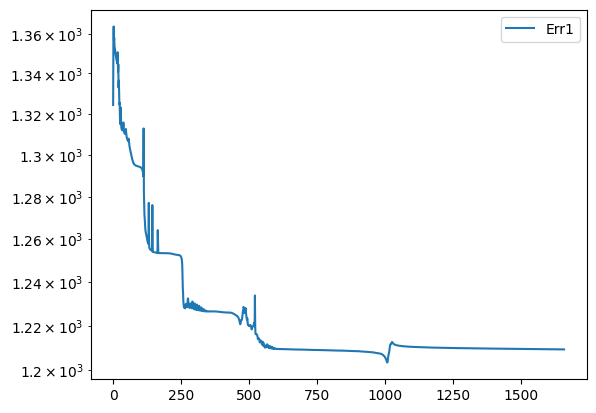

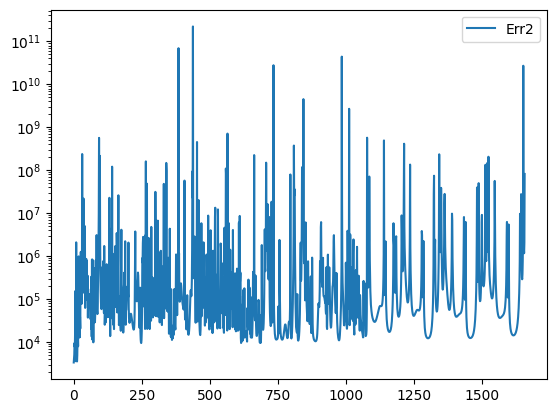

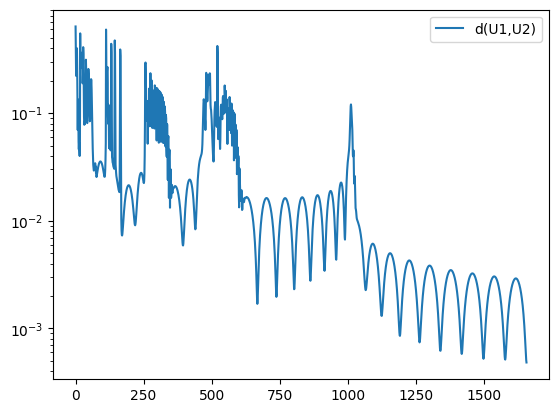

In [ ]:
plt.figure(1)
plt.semilogy(fv1)
plt.legend(['Err1'])

plt.figure(2)
plt.semilogy(fv2)
plt.legend(['Err2'])

plt.figure(3)
plt.semilogy(fd)
plt.legend(['d(U1,U2)'])


After 1658 iterations, the algorithm converged to a solution which gives an approximation error $$f = \|Y_1 - U_1 V_1\|_F^2 + \|Y_2 - U_2 V_2\|_F^2 = 1209.34513$$ with the relative error betwen $U_1$ and $U_2$
$$\frac{\|U_1 - U_2\|_F}{\|U_1\|_F} = 0.00015$$

Note that this approximation is even better than the best approximation error of $1502.59665$. The obtained factor matrices encounted degeneracy and have rank 2.


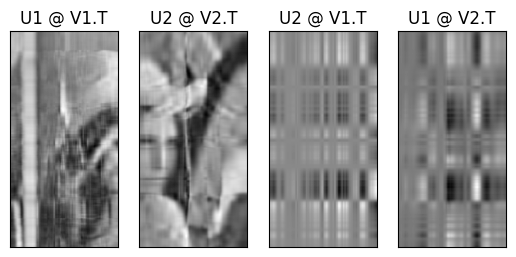

In [ ]:
plt.subplot(1,4,1)
plt.imshow(Ux[0] @ Vx[0], cmap='gray')
plt.title('U1 @ V1.T')
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,2)
plt.imshow(Ux[1] @ Vx[1], cmap='gray')
plt.title('U2 @ V2.T')
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,3)
plt.imshow(Ux[1] @ Vx[0], cmap='gray')
plt.title('U2 @ V1.T')
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,4)
plt.imshow(Ux[0] @ Vx[1], cmap='gray')
plt.title('U1 @ V2.T')
plt.xticks([])
plt.yticks([])

plt.show()

Singular values of U1  [1.99154044e+00 1.80481289e+00 1.66621626e+00 1.18531918e-02
 7.11313320e-06 1.79908846e-06 7.93174786e-07 4.23578549e-08
 5.59302902e-09 1.37084304e-10]
Singular values of U2  [1.99154064e+00 1.80481330e+00 1.66621564e+00 1.18434663e-02
 5.17158178e-06 1.32095485e-06 5.09085617e-07 3.06242586e-08
 5.86025619e-09 1.33029187e-09]


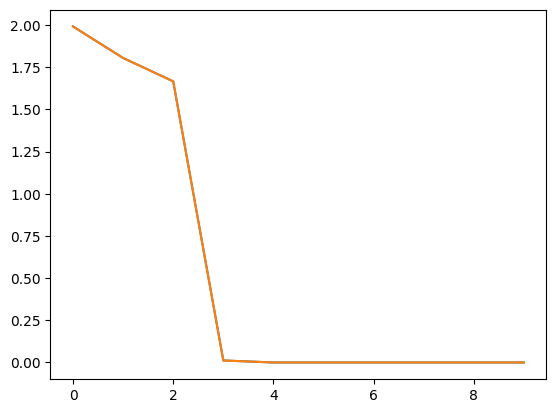

In [ ]:
s1 = np.linalg.svd(Ux[0])[1]
print("Singular values of U1 ", s1)
s2 = np.linalg.svd(Ux[1])[1]
print("Singular values of U2 ", s2)

plt.plot(np.linalg.svd(Ux[0])[1])
plt.plot(np.linalg.svd(Ux[1])[1])

In [ ]:
# Relative error between U1 and U2

np.linalg.norm(Ux[0]-Ux[1],ord = 'fro')/np.linalg.norm(Ux[0],ord = 'fro')

0.00015290142459377495

**Example 2:** Run ADMM with parameter $\lambda$ adaptively adjusted


In [ ]:
Ux = []
Vx = []

for i in range(len(Yc)):
    uk,sk,vk = np.linalg.svd(Yc[i], full_matrices = False)
    Ux.append(uk[:,:R])
    Vx.append(np.diag(sk[:R]) @ vk[:R,:])


lambda_ = 1e3
fv1 = []
fv2 = []
fd = []

while 1:
  [Ux,Vx,fv1_,fv2_,fd_] = admm_lr_distributed(Yc,R,lambda_,Ux,Vx, verbose = 1,maxiters = 10000)

  lambda_ = min(1e5,lambda_ * 2)

  fv1.extend(fv1_)
  fv2.extend(fv2_)
  fd.extend(fd_)

  if fd_[-1] <= 1e-4:
      break

Iteration 0, Err1: 1696.69722, Err2: 2513.44832, Diff: 0.12720
Iteration 1, Err1: 1676.08896, Err2: 2388.23056, Diff: 0.10426
Iteration 2, Err1: 1659.43979, Err2: 2284.67367, Diff: 0.09074
Iteration 3, Err1: 1642.73343, Err2: 2199.46948, Diff: 0.08221
Iteration 4, Err1: 1624.69014, Err2: 2137.16700, Diff: 0.07790
Iteration 5, Err1: 1605.72636, Err2: 2096.72326, Diff: 0.07734
Iteration 6, Err1: 1587.31942, Err2: 2060.29143, Diff: 0.07834
Iteration 7, Err1: 1571.03965, Err2: 2000.49332, Diff: 0.07764
Iteration 8, Err1: 1557.79912, Err2: 1907.63305, Diff: 0.07313
Iteration 9, Err1: 1547.74390, Err2: 1801.12121, Diff: 0.06520
Iteration 10, Err1: 1540.43800, Err2: 1708.32260, Diff: 0.05596
Iteration 11, Err1: 1535.13456, Err2: 1642.43464, Diff: 0.04760
Iteration 12, Err1: 1531.09451, Err2: 1601.51332, Diff: 0.04122
Iteration 13, Err1: 1527.78396, Err2: 1577.72893, Diff: 0.03683
Iteration 14, Err1: 1524.89574, Err2: 1563.83820, Diff: 0.03381
Iteration 15, Err1: 1522.28361, Err2: 1555.04117, 

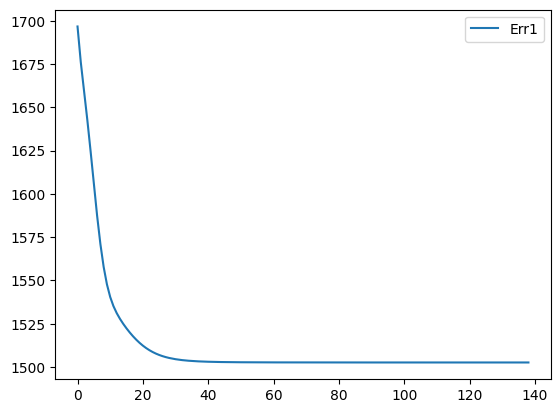

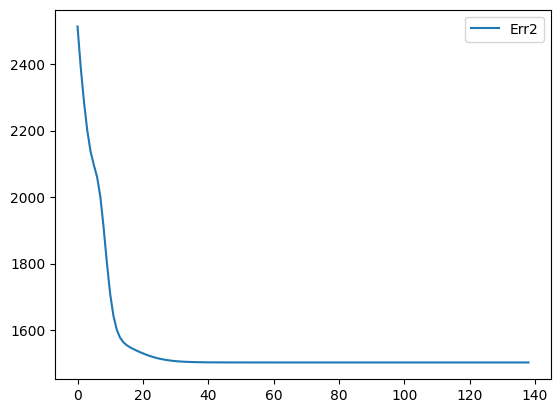

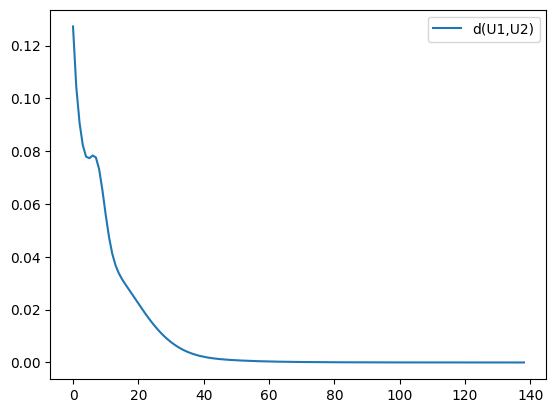

In [ ]:
plt.figure(1)
plt.plot(fv1)
plt.legend(['Err1'])
plt.show()

plt.figure(2)
plt.plot(fv2)
plt.legend(['Err2'])

plt.figure(3)
plt.plot(fd)
plt.legend(['d(U1,U2)'])

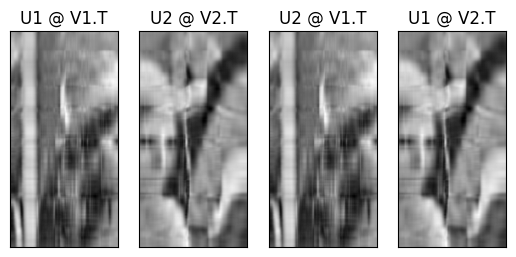

In [ ]:
plt.subplot(1,4,1)
plt.imshow(Ux[0] @ Vx[0], cmap='gray')
plt.title('U1 @ V1.T')
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,2)
plt.imshow(Ux[1] @ Vx[1], cmap='gray')
plt.title('U2 @ V2.T')
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,3)
plt.imshow(Ux[1] @ Vx[0], cmap='gray')
plt.title('U2 @ V1.T')
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,4)
plt.imshow(Ux[0] @ Vx[1], cmap='gray')
plt.title('U1 @ V2.T')
plt.xticks([])
plt.yticks([])

plt.show()